# STOR 320: Introduction to Data Science


## Part 1: Data cleaning, merging, and visualization (6 points)

In [922]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from geopy.distance import geodesic
from scipy.stats import ttest_ind
import math

In [923]:
flights = pd.read_csv('flights.csv')
hotel = pd.read_csv('hotel_bookings.csv')

In [924]:
## column names check (1 point)
print(flights.columns)
hotel.columns

Index(['id', 'year', 'month', 'day', 'dep_time', 'sched_dep_time', 'dep_delay',
       'arr_time', 'sched_arr_time', 'arr_delay', 'carrier', 'flight',
       'tailnum', 'origin', 'dest', 'air_time', 'distance', 'hour', 'minute',
       'time_hour', 'name'],
      dtype='object')


Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

In [925]:
## missing data check (1 point)
print(flights.isnull().sum())
hotel.isnull().sum()

id                   0
year                 0
month                0
day                  0
dep_time          8255
sched_dep_time       0
dep_delay         8255
arr_time          8713
sched_arr_time       0
arr_delay         9430
carrier              0
flight               0
tailnum           2512
origin               0
dest                 0
air_time          9430
distance             0
hour                 0
minute               0
time_hour            0
name                 0
dtype: int64


hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

           arr_delay      dep_delay       distance       air_time
count  327346.000000  328521.000000  336776.000000  327346.000000
mean        6.895377      12.639070    1039.912604     150.686460
std        44.633292      40.210061     733.233033      93.688305
min       -86.000000     -43.000000      17.000000      20.000000
25%       -17.000000      -5.000000     502.000000      82.000000
50%        -5.000000      -2.000000     872.000000     129.000000
75%        14.000000      11.000000    1389.000000     192.000000
max      1272.000000    1301.000000    4983.000000     695.000000
           lead_time  previous_cancellations  previous_bookings_not_canceled  \
count  119390.000000           119390.000000                   119390.000000   
mean      104.011416                0.087118                        0.137097   
std       106.863097                0.844336                        1.497437   
min         0.000000                0.000000                        0.000000   
25%   

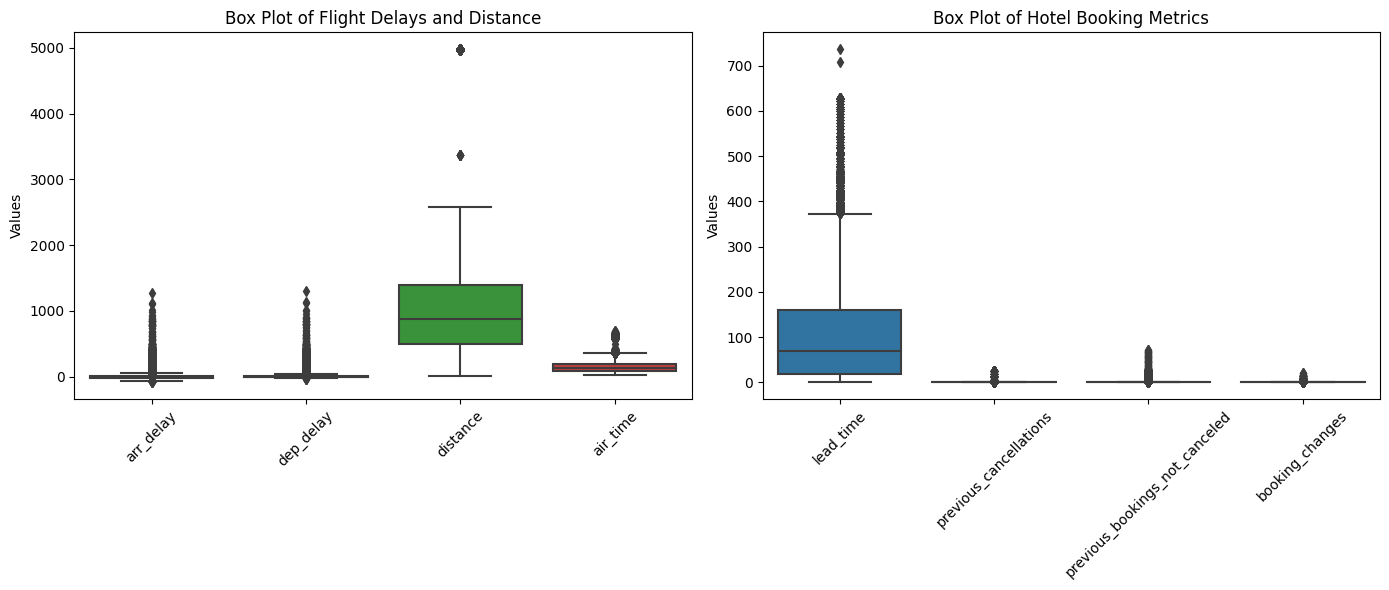

In [926]:
## Outlier check (1 point)
print(flights.describe()[['arr_delay','dep_delay','distance','air_time']])
print(hotel.describe()[['lead_time','previous_cancellations','previous_bookings_not_canceled','booking_changes']])

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.boxplot(data=flights[['arr_delay', 'dep_delay', 'distance', 'air_time']])
plt.title('Box Plot of Flight Delays and Distance')
plt.ylabel('Values')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.boxplot(data=hotel[['lead_time', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes']])
plt.title('Box Plot of Hotel Booking Metrics')
plt.ylabel('Values')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [929]:
## data merging (1 point)
month_mapping = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}
hotel['arrival_date_month_numeric'] = hotel['arrival_date_month'].map(month_mapping)

flights['month'] = flights['month'].astype(int)
flights['day'] = flights['day'].astype(int)
hotel['arrival_date_month_numeric'] = hotel['arrival_date_month_numeric'].astype(int)
hotel['arrival_date_day_of_month'] = hotel['arrival_date_day_of_month'].astype(int)
hotel['arrival_date_year'] = hotel['arrival_date_year'].astype(int)

hotel_filtered = hotel[
    (hotel['country'] == 'USA') & 
    (hotel['arrival_date_year'] == 2016) 
]
merged_data = pd.merge(
    flights, hotel_filtered, 
    left_on=['month', 'day'], 
    right_on=['arrival_date_month_numeric', 'arrival_date_day_of_month'], 
    how='inner'
)
merged_data[['hour','origin','dest','time_hour','name']]

,hour,origin,dest,time_hour,name
0,5,EWR,IAH,2013-01-01 05:00:00,United Air Lines Inc.
1,5,LGA,IAH,2013-01-01 05:00:00,United Air Lines Inc.
2,5,JFK,MIA,2013-01-01 05:00:00,American Airlines Inc.
3,5,JFK,BQN,2013-01-01 05:00:00,JetBlue Airways
4,6,LGA,ATL,2013-01-01 06:00:00,Delta Air Lines Inc.
...,...,...,...,...,...
900718,11,LGA,CLE,2013-09-30 11:00:00,Envoy Air
900719,11,LGA,CLE,2013-09-30 11:00:00,Envoy Air
900720,8,LGA,RDU,2013-09-30 08:00:00,Envoy Air
900721,8,LGA,RDU,2013-09-30 08:00:00,Envoy Air


In [76]:
## data transformation, normalization, and cleaning (1 point)

In [930]:
merged_data.columns

Index(['id', 'year', 'month', 'day', 'dep_time', 'sched_dep_time', 'dep_delay',
       'arr_time', 'sched_arr_time', 'arr_delay', 'carrier', 'flight',
       'tailnum', 'origin', 'dest', 'air_time', 'distance', 'hour', 'minute',
       'time_hour', 'name', 'hotel', 'is_canceled', 'lead_time',
       'arrival_date_year', 'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date',
       'arrival_date_month_numeric'],
      dtype='obje

In [931]:
clean_merged_data = merged_data[[#'id', 
    'year', 'month', 'day', 'dep_time', 'sched_dep_time', 'dep_delay',
       'arr_time', 'sched_arr_time', 'arr_delay', 'carrier', 
       #'flight','tailnum', 
       'origin', 'dest', 'air_time', 'distance',
        'hour', 'minute', 'time_hour', 
        'name', 
        
        'hotel', 'is_canceled', 'lead_time',
       'arrival_date_year', 'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 
       #'meal',
       'country', 
       'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 
       #'reserved_room_type',
       #'assigned_room_type', 
       'booking_changes', 
       'deposit_type', 
       #'agent',
       #'company', 
       'days_in_waiting_list', 'customer_type', 
       'adr',
       'required_car_parking_spaces', 'total_of_special_requests', 'reservation_status',
       'reservation_status_date',
       'arrival_date_month_numeric']].dropna()
clean_merged_data

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,...,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date_month_numeric
0,2013,1,1,517.0,515,2.0,830.0,819,11.0,UA,...,0,No Deposit,0,Transient,92.0,0,1,Check-Out,2016-01-03,1
1,2013,1,1,533.0,529,4.0,850.0,830,20.0,UA,...,0,No Deposit,0,Transient,92.0,0,1,Check-Out,2016-01-03,1
2,2013,1,1,542.0,540,2.0,923.0,850,33.0,AA,...,0,No Deposit,0,Transient,92.0,0,1,Check-Out,2016-01-03,1
3,2013,1,1,544.0,545,-1.0,1004.0,1022,-18.0,B6,...,0,No Deposit,0,Transient,92.0,0,1,Check-Out,2016-01-03,1
4,2013,1,1,554.0,600,-6.0,812.0,837,-25.0,DL,...,0,No Deposit,0,Transient,92.0,0,1,Check-Out,2016-01-03,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
900700,2013,9,30,2307.0,2255,12.0,2359.0,2358,1.0,B6,...,0,No Deposit,0,Transient,136.0,1,1,Check-Out,2016-10-01,9
900701,2013,9,30,2307.0,2255,12.0,2359.0,2358,1.0,B6,...,1,No Deposit,0,Transient,215.0,0,0,Check-Out,2016-10-03,9
900702,2013,9,30,2349.0,2359,-10.0,325.0,350,-25.0,B6,...,0,No Deposit,0,Transient,139.0,0,0,Canceled,2016-07-23,9
900703,2013,9,30,2349.0,2359,-10.0,325.0,350,-25.0,B6,...,0,No Deposit,0,Transient,136.0,1,1,Check-Out,2016-10-01,9


In [932]:
merged_data['arrival_date'] = pd.to_datetime(
    merged_data['arrival_date_year'].astype(str) + '-' +
    merged_data['arrival_date_month_numeric'].astype(str) + '-' +
    merged_data['arrival_date_day_of_month'].astype(str),
    errors='coerce'
)

merged_data.drop(['arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month', 'arrival_date_month_numeric'], axis=1, inplace=True)

merged_data[['arrival_date']].head()

#makes a date time column

,arrival_date
0,2016-01-01
1,2016-01-01
2,2016-01-01
3,2016-01-01
4,2016-01-01


In [933]:
clean_merged_data['arrival_date'] = pd.to_datetime(
    clean_merged_data['arrival_date_year'].astype(str) + '-' +
    clean_merged_data['arrival_date_month_numeric'].astype(str) + '-' +
    clean_merged_data['arrival_date_day_of_month'].astype(str),
    errors='coerce'
)

clean_merged_data.drop(['arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month', 'arrival_date_month_numeric'], axis=1, inplace=True)

clean_merged_data[['arrival_date']].head()

#makes a date time column

,arrival_date
0,2016-01-01
1,2016-01-01
2,2016-01-01
3,2016-01-01
4,2016-01-01


In [934]:
merged_data['arrival_date'] = pd.to_datetime(merged_data['arrival_date'], errors='coerce')
merged_data['reservation_status_date'] = pd.to_datetime(merged_data['reservation_status_date'], errors='coerce')

#  Convers to data time

In [935]:
clean_merged_data['arrival_date'] = pd.to_datetime(clean_merged_data['arrival_date'], errors='coerce')
clean_merged_data['reservation_status_date'] = pd.to_datetime(clean_merged_data['reservation_status_date'], errors='coerce')

#  Convers to data time

In [936]:
merged_data['dep_time_full'] = pd.to_datetime(merged_data['arrival_date'].astype(str) + ' ' + 
                                              merged_data['hour'].astype(str) + ':' + 
                                              merged_data['minute'].astype(str), errors='coerce')

# Reformats to date time

In [937]:
clean_merged_data['dep_time_full'] = pd.to_datetime(clean_merged_data['arrival_date'].astype(str) + ' ' + 
                                              clean_merged_data['hour'].astype(str) + ':' + 
                                              clean_merged_data['minute'].astype(str), errors='coerce')

# Reformats to date time

In [938]:
if 'dep_time' in merged_data.columns and 'sched_dep_time' in merged_data.columns:
    merged_data['dep_time'] = pd.to_datetime(merged_data['dep_time'], format='%H%M', errors='coerce')
    merged_data['sched_dep_time'] = pd.to_datetime(merged_data['sched_dep_time'], format='%H%M', errors='coerce')
    merged_data['dep_delay_calc'] = (merged_data['dep_time'] - merged_data['sched_dep_time']).dt.total_seconds() / 60

In [939]:
if 'dep_time' in clean_merged_data.columns and 'sched_dep_time' in clean_merged_data.columns:
    clean_merged_data['dep_time'] = pd.to_datetime(clean_merged_data['dep_time'], format='%H%M', errors='coerce')
    clean_merged_data['sched_dep_time'] = pd.to_datetime(clean_merged_data['sched_dep_time'], format='%H%M', errors='coerce')
    clean_merged_data['dep_delay_calc'] = (clean_merged_data['dep_time'] - clean_merged_data['sched_dep_time']).dt.total_seconds() / 60

In [940]:
if 'arr_time' in merged_data.columns and 'sched_arr_time' in merged_data.columns:
    merged_data['arr_time'] = pd.to_datetime(merged_data['arr_time'], format='%H%M', errors='coerce')
    merged_data['sched_arr_time'] = pd.to_datetime(merged_data['sched_arr_time'], format='%H%M', errors='coerce')
    merged_data['arr_delay_calc'] = (merged_data['arr_time'] - merged_data['sched_arr_time']).dt.total_seconds() / 60

# Calculate delays based on existing columns if dep_time and sched_dep_time are present as times

In [941]:
if 'arr_time' in clean_merged_data.columns and 'sched_arr_time' in clean_merged_data.columns:
    clean_merged_data['arr_time'] = pd.to_datetime(clean_merged_data['arr_time'], format='%H%M', errors='coerce')
    clean_merged_data['sched_arr_time'] = pd.to_datetime(clean_merged_data['sched_arr_time'], format='%H%M', errors='coerce')
    clean_merged_data['arr_delay_calc'] = (clean_merged_data['arr_time'] - clean_merged_data['sched_arr_time']).dt.total_seconds() / 60

# Calculate delays based on existing columns if dep_time and sched_dep_time are present as times

In [942]:
continuous_features = ['dep_delay', 'arr_delay', 'lead_time', 'air_time', 'distance', 'days_in_waiting_list', 'adr']
scaler = StandardScaler()
merged_data[continuous_features] = scaler.fit_transform(merged_data[continuous_features])
#  Scales featues that may need tranformation

In [943]:
continuous_features = ['dep_delay', 'arr_delay', 'lead_time', 'air_time', 'distance', 'days_in_waiting_list', 'adr']
scaler = StandardScaler()
clean_merged_data[continuous_features] = scaler.fit_transform(clean_merged_data[continuous_features])
#  Scales featues that may need tranformation

In [944]:
categorical_features = ['company', 'carrier', 
                        'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type']
merged_data = pd.get_dummies(merged_data, columns=categorical_features, drop_first=True)
#  Takes data and makes it into diffrent catigoireis for later analysis

In [945]:
categorical_features = [#'company',
     'carrier', 
                       # 'meal', 'country', 
                       'market_segment', 'distribution_channel'
                       #'reserved_room_type', 'assigned_room_type'
                       ]
clean_merged_data = pd.get_dummies(clean_merged_data, columns=categorical_features, drop_first=True)
#  Takes data and makes it into diffrent catigoireis for later analysis

In [946]:
binary_features = ['is_canceled', 'is_repeated_guest', 'required_car_parking_spaces']
merged_data[binary_features] = merged_data[binary_features].astype(int)
#  Turn binary data into binary (self expanitory)

In [947]:
binary_features = ['is_canceled', 'is_repeated_guest', 'required_car_parking_spaces']
clean_merged_data[binary_features] = clean_merged_data[binary_features].astype(int)
#  Turn binary data into binary (self expanitory)

In [948]:
count_features = ['previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'total_of_special_requests']
merged_data[count_features] = scaler.fit_transform(merged_data[count_features])
	
# Calculates the mean and standard deviation then applies the transformation to the data using the parameters

In [949]:
count_features = ['previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'total_of_special_requests']
clean_merged_data[count_features] = scaler.fit_transform(clean_merged_data[count_features])
	
# Calculates the mean and standard deviation then applies the transformation to the data using the parameters

In [950]:
merged_data['total_guests'] = merged_data[['adults', 'children', 'babies']].sum(axis=1)
# Summing the total amounts of guests

In [951]:
clean_merged_data['total_guests'] = clean_merged_data[['adults', 'children', 'babies']].sum(axis=1)
# Summing the total amounts of guests

In [952]:
merged_data['reservation_status'] = merged_data['reservation_status'].astype('category').cat.codes
# Convert regitration status to numerical codes

In [953]:
clean_merged_data['reservation_status'] = clean_merged_data['reservation_status'].astype('category').cat.codes
# Convert regitration status to numerical codes

In [954]:
merged_data.columns

Index(['id', 'year', 'month', 'day', 'dep_time', 'sched_dep_time', 'dep_delay',
       'arr_time', 'sched_arr_time', 'arr_delay', 'flight', 'tailnum',
       'origin', 'dest', 'air_time', 'distance', 'hour', 'minute', 'time_hour',
       'name', 'hotel', 'is_canceled', 'lead_time', 'arrival_date_week_number',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'deposit_type',
       'agent', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'arrival_date',
       'dep_time_full', 'dep_delay_calc', 'arr_delay_calc', 'company_153.0',
       'company_169.0', 'company_174.0', 'company_183.0', 'company_197.0',
       'company_293.0', 'company_332.0', 'company_351.0', 'company_360.0',
       'carrier_AA', 'carrier_AS', 'car

In [955]:
clean_merged_data.columns

Index(['year', 'month', 'day', 'dep_time', 'sched_dep_time', 'dep_delay',
       'arr_time', 'sched_arr_time', 'arr_delay', 'origin', 'dest', 'air_time',
       'distance', 'hour', 'minute', 'time_hour', 'name', 'hotel',
       'is_canceled', 'lead_time', 'arrival_date_week_number',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'country', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'deposit_type',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'arrival_date',
       'dep_time_full', 'dep_delay_calc', 'arr_delay_calc', 'carrier_AA',
       'carrier_AS', 'carrier_B6', 'carrier_DL', 'carrier_EV', 'carrier_F9',
       'carrier_FL', 'carrier_HA', 'carrier_MQ', 'carrier_OO', 'carrier_UA',
       'carrier_US', 'carrier_VX', 'carrier_WN', 'carrier_YV',


In [90]:
## Exploratory data visualization (1 point)

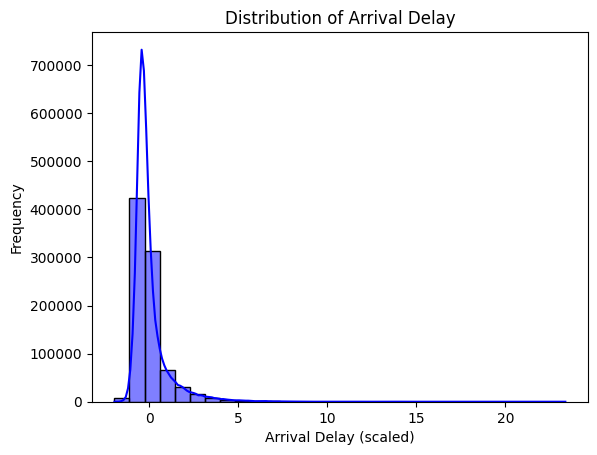

In [956]:
sns.histplot(merged_data['arr_delay'], bins=30, kde=True, color='blue')
plt.title('Distribution of Arrival Delay')
plt.xlabel('Arrival Delay (scaled)')
plt.ylabel('Frequency')
plt.show()

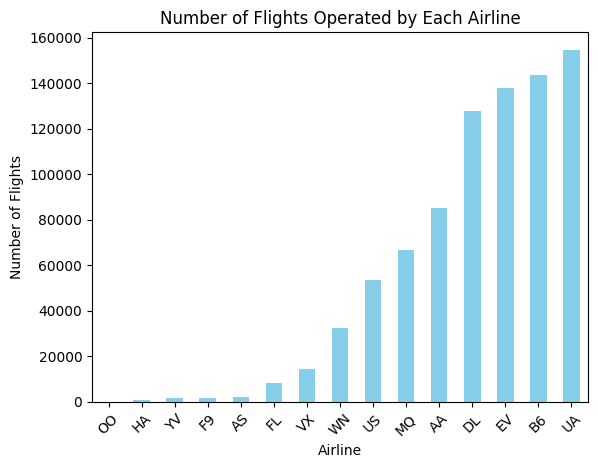

In [957]:

# Count the number of flights per carrier
carrier_columns = [col for col in clean_merged_data.columns if col.startswith('carrier_')]
flight_counts = clean_merged_data[carrier_columns].sum()
flight_counts.index = flight_counts.index.str.replace('carrier_', '')

flight_counts.sort_values().plot(kind='bar', color='skyblue')
plt.title('Number of Flights Operated by Each Airline')
plt.xlabel('Airline')
plt.ylabel('Number of Flights')
plt.xticks(rotation=45)
plt.show()

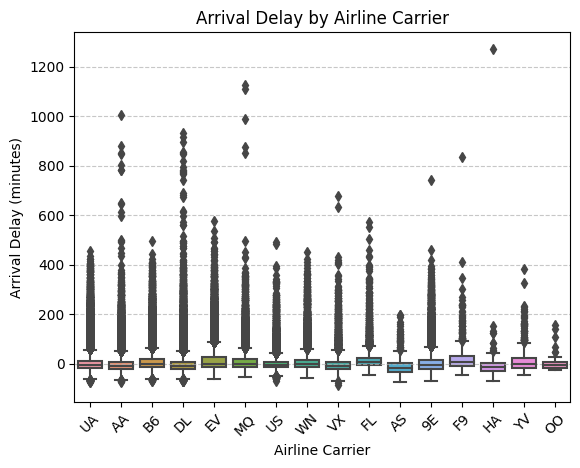

In [958]:
sns.boxplot(x='carrier', y='arr_delay', data=flights)
plt.title('Arrival Delay by Airline Carrier')
plt.xlabel('Airline Carrier')
plt.ylabel('Arrival Delay (minutes)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

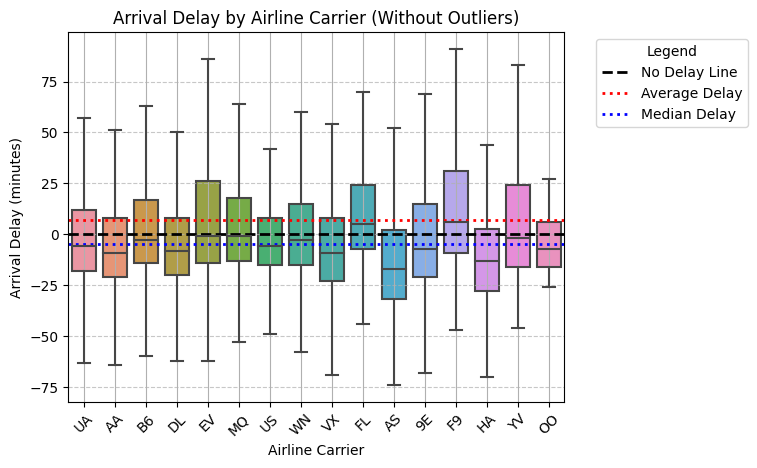

In [959]:
overall_average_delay_per_month = flights['arr_delay'].mean()
overall_median_delay = flights['arr_delay'].median()
sns.boxplot(x='carrier', y='arr_delay', data=flights, showfliers=False)
plt.title('Arrival Delay by Airline Carrier (Without Outliers)')
plt.xlabel('Airline Carrier')
plt.ylabel('Arrival Delay (minutes)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.axhline(y=0, color='black', linewidth=2, linestyle='--', label='No Delay Line')
plt.axhline(y=overall_average_delay_per_month, color='red', linewidth=2, linestyle=':', label='Average Delay')
plt.axhline(y=overall_median_delay, color='blue', linewidth=2, linestyle=':', label='Median Delay')
plt.grid(True)
plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

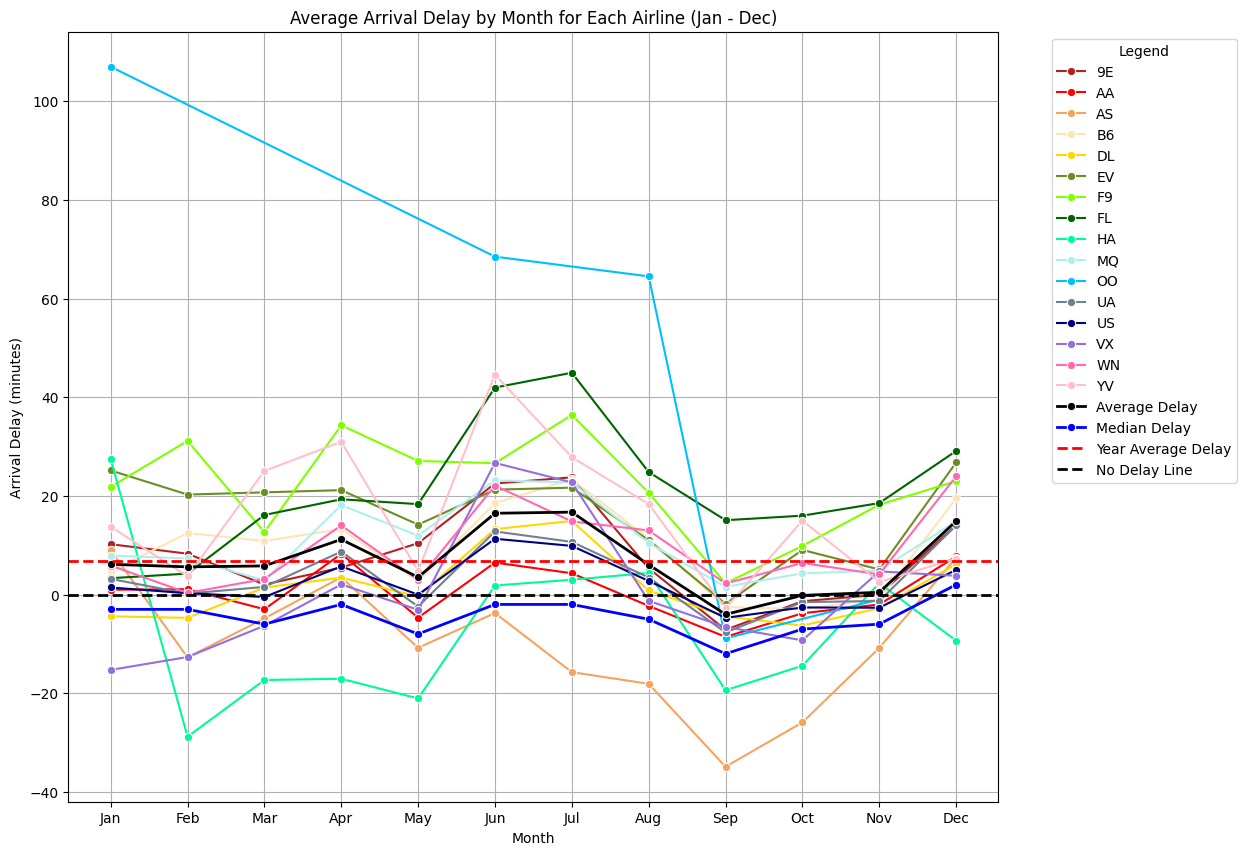

In [1071]:
# month_mapping = {'1': 1,'2': 2,'3': 3,'4': 4,'5': 5,'6': 6,'7': 7,'8': 8,'9': 9,'10': 10,'11': 11,'12': 12}
month_mapping = {1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12}
flights['month_numeric'] = flights['month'].map(month_mapping)
average_delay_per_month = (flights.groupby(['month_numeric', 'carrier'])['arr_delay'].mean().reset_index())
overall_average_delay_per_month = (flights.groupby('month_numeric')['arr_delay'].mean().reset_index().rename(columns={'arr_delay': 'overall_avg_delay'}))
overall_median_delay_per_month = (flights.groupby('month_numeric')['arr_delay'].median().reset_index().rename(columns={'arr_delay': 'overall_median_delay'}))
year_average_delay = flights['arr_delay'].mean()
unique_carriers = average_delay_per_month['carrier'].unique()
custom_colors = ['firebrick', 'red', 'sandybrown', 'moccasin', 'gold', 'olivedrab', 
                 'chartreuse', 'darkgreen', 'mediumspringgreen', 'paleturquoise', 
                 'deepskyblue', 'slategray', 'navy', 'mediumpurple', 'hotpink', 'pink']

plt.figure(figsize=(12, 10))
for i, carrier in enumerate(unique_carriers):
    sns.lineplot(data=average_delay_per_month[average_delay_per_month['carrier'] == carrier],
                 x='month_numeric',
                 y='arr_delay',
                 color=custom_colors[i],
                 marker='o',
                 label=carrier)
sns.lineplot(data=overall_average_delay_per_month, x='month_numeric', y='overall_avg_delay', color='black', marker='o', label='Average Delay', linewidth=2)
sns.lineplot(data=overall_median_delay_per_month, x='month_numeric', y='overall_median_delay', color='blue', marker='o', label='Median Delay', linewidth=2)
plt.axhline(y=year_average_delay, color='red', linestyle='--', label='Year Average Delay', linewidth=2)
plt.title('Average Arrival Delay by Month for Each Airline (Jan - Dec)')
plt.xlabel('Month')
plt.ylabel('Arrival Delay (minutes)')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.axhline(y=0, color='black', linewidth=2, linestyle='--', label='No Delay Line')
plt.grid(True)
plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

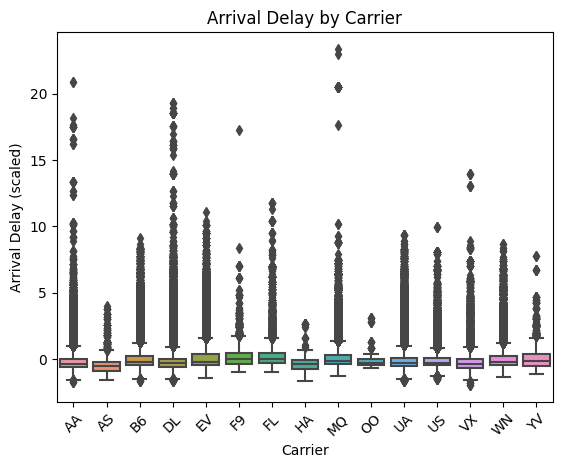

In [961]:
# select only the carrier dummy columns
carrier_cols = [col for col in clean_merged_data.columns if col.startswith("carrier_")]
df_carrier = clean_merged_data[carrier_cols + ['arr_delay']]
# melt the data
df_carrier_melted = df_carrier.melt(id_vars=['arr_delay'], var_name='carrier', value_name='indicator')
df_carrier_melted = df_carrier_melted[df_carrier_melted['indicator'] == 1]
df_carrier_melted['carrier'] = df_carrier_melted['carrier'].str.replace("carrier_", "")

sns.boxplot(x='carrier', y='arr_delay', data=df_carrier_melted)
plt.title('Arrival Delay by Carrier')
plt.xlabel('Carrier')
plt.ylabel('Arrival Delay (scaled)')
plt.xticks(rotation=45)
plt.show()

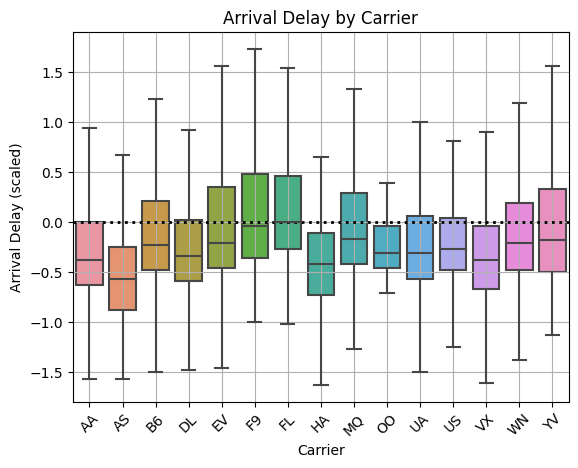

In [962]:
# select only the carrier dummy columns
carrier_cols = [col for col in clean_merged_data.columns if col.startswith("carrier_")]
df_carrier = clean_merged_data[carrier_cols + ['arr_delay']]
# melt the data
df_carrier_melted = df_carrier.melt(id_vars=['arr_delay'], var_name='carrier', value_name='indicator')
df_carrier_melted = df_carrier_melted[df_carrier_melted['indicator'] == 1]
df_carrier_melted['carrier'] = df_carrier_melted['carrier'].str.replace("carrier_", "")

sns.boxplot(x='carrier', y='arr_delay', data=df_carrier_melted, showfliers=False)
plt.title('Arrival Delay by Carrier')
plt.xlabel('Carrier')
plt.ylabel('Arrival Delay (scaled)')
plt.axhline(y=0, color='black', linewidth=2, linestyle=':', label='Average Delay Line')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

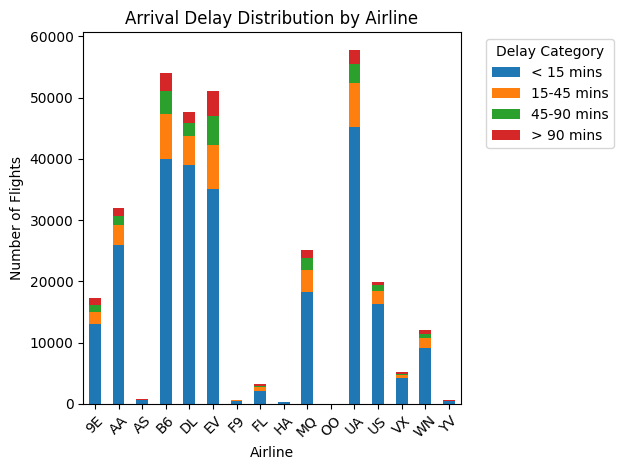

In [963]:
delay_bins = [-float('inf'), 15, 45, 90, float('inf')]
delay_labels = ['< 15 mins', '15-45 mins', '45-90 mins', '> 90 mins']
flights['delay_category'] = pd.cut(flights['arr_delay'], bins=delay_bins, labels=delay_labels)
delay_counts = flights.groupby(['carrier', 'delay_category']).size().unstack(fill_value=0)
delay_counts.plot(kind='bar', stacked=True)
plt.title('Arrival Delay Distribution by Airline')
plt.xlabel('Airline')
plt.ylabel('Number of Flights')
plt.xticks(rotation=45)
plt.legend(title='Delay Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

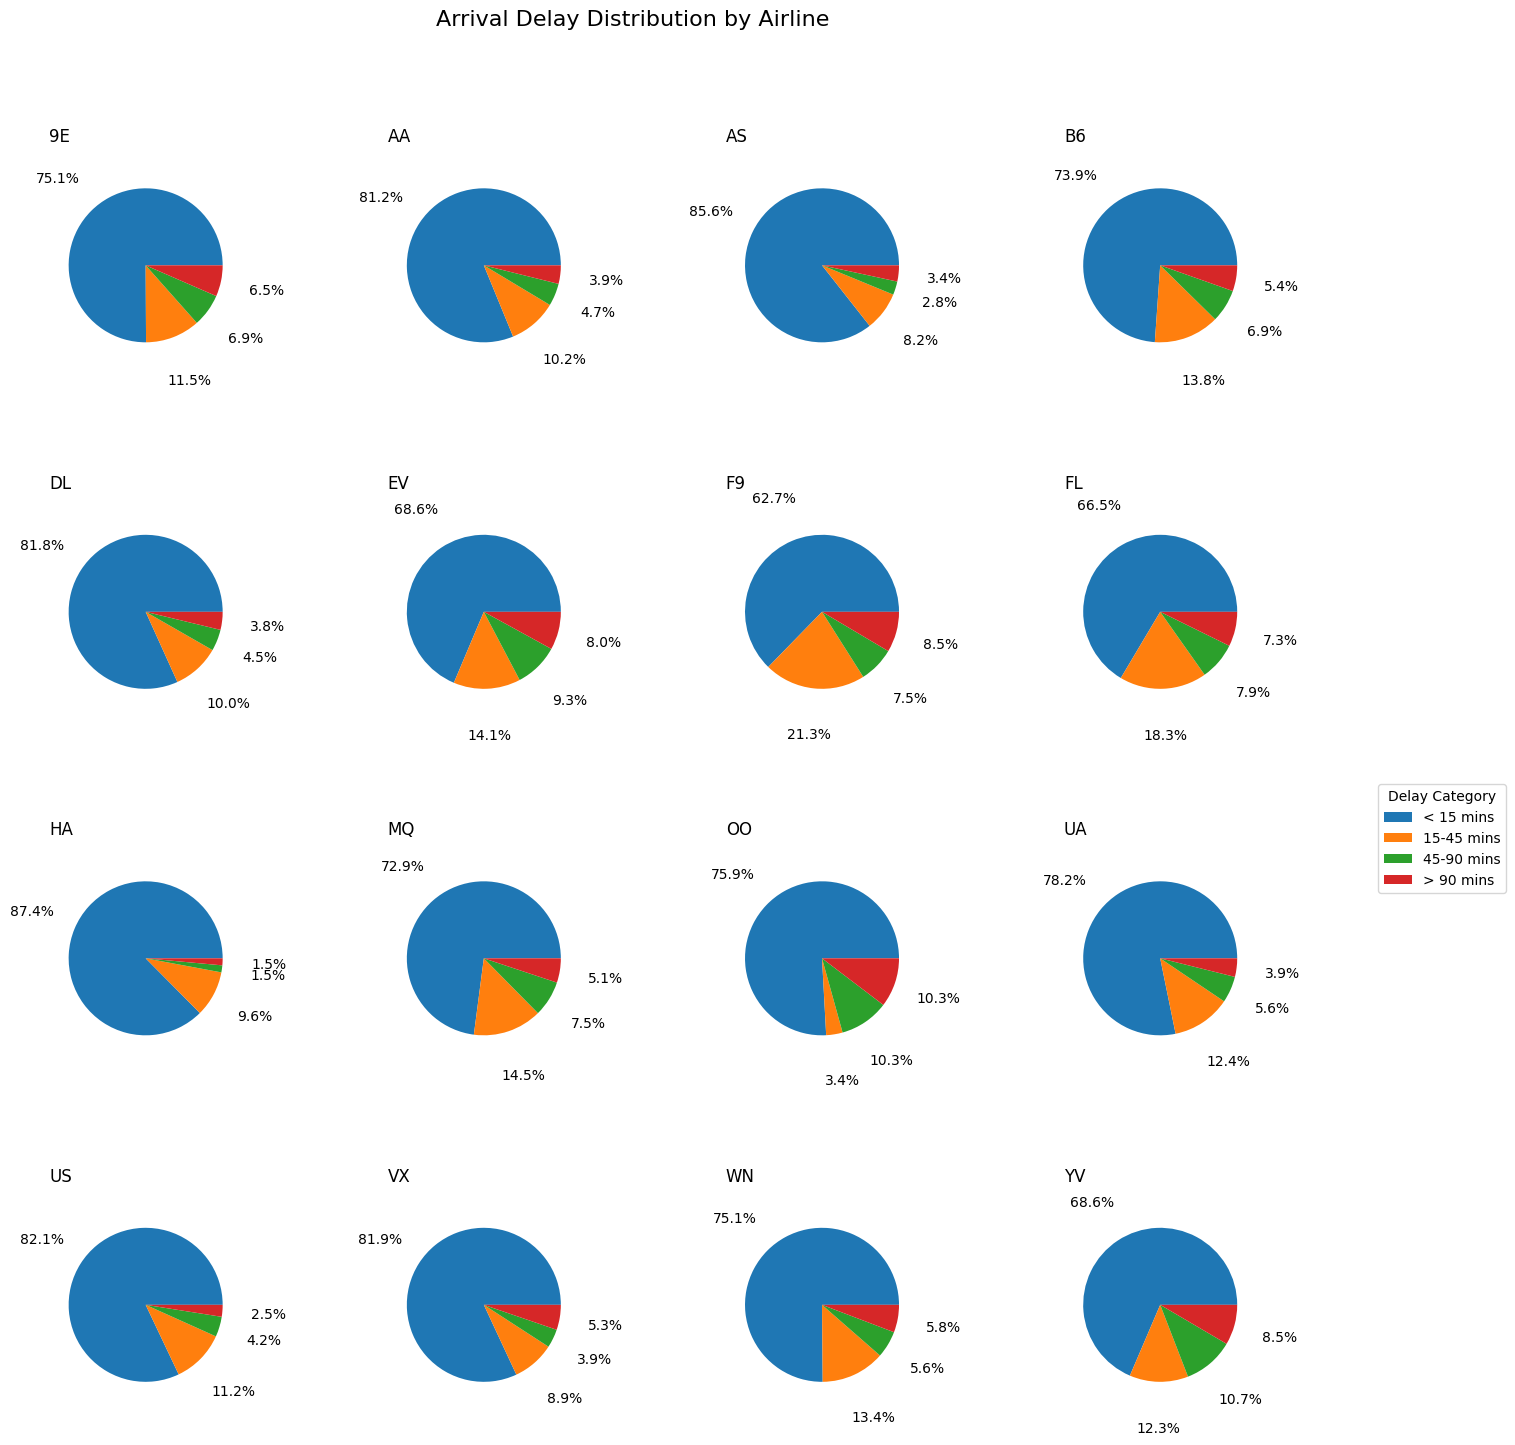

In [964]:
delay_bins = [-float('inf'), 15, 45, 90, float('inf')]
delay_labels = ['< 15 mins', '15-45 mins', '45-90 mins', '> 90 mins']
flights['delay_category'] = pd.cut(flights['arr_delay'], bins=delay_bins, labels=delay_labels)

delay_counts = flights.groupby(['carrier', 'delay_category']).size().unstack(fill_value=0)

fig, axes = plt.subplots(4, 4, figsize=(16, 16), subplot_kw=dict(aspect="equal"))
axes = axes.flatten()
for i, (carrier, counts) in enumerate(delay_counts.iterrows()):
    ax = axes[i]
    wedges, texts, autotexts = ax.pie(counts, labels=None, autopct='%1.1f%%', pctdistance=1.6, labeldistance=1.5)
    ax.set_title(carrier, fontsize=12, loc='left', pad=20)
fig.legend(wedges, delay_labels, title='Delay Category', bbox_to_anchor=(1.05, 0.5))
plt.suptitle('Arrival Delay Distribution by Airline', fontsize=16)
plt.subplots_adjust(wspace=0.5, hspace=0.8)
plt.show()

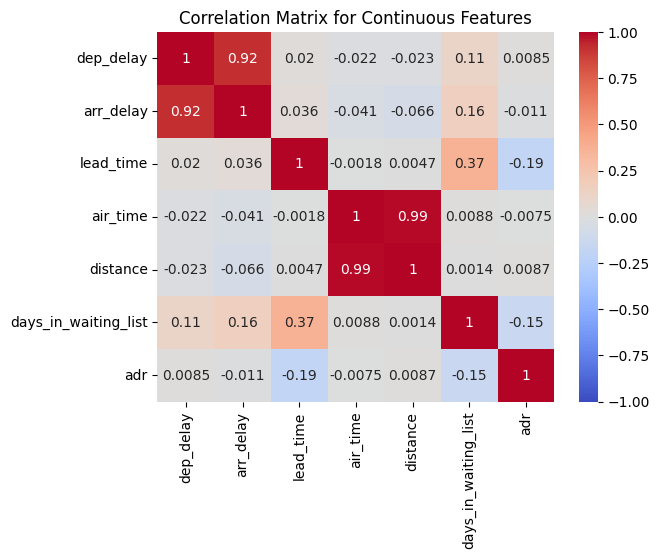

In [917]:
sns.heatmap(merged_data[continuous_features].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix for Continuous Features')
plt.show()

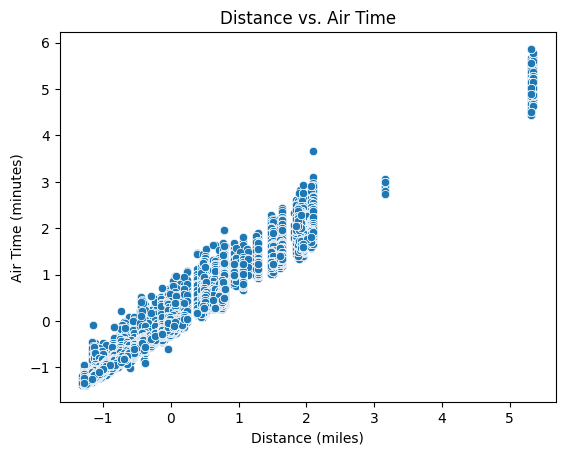

In [918]:
sns.scatterplot(x='distance', y='air_time', data=merged_data)
plt.title('Distance vs. Air Time')
plt.xlabel('Distance (miles)')
plt.ylabel('Air Time (minutes)')
plt.show()

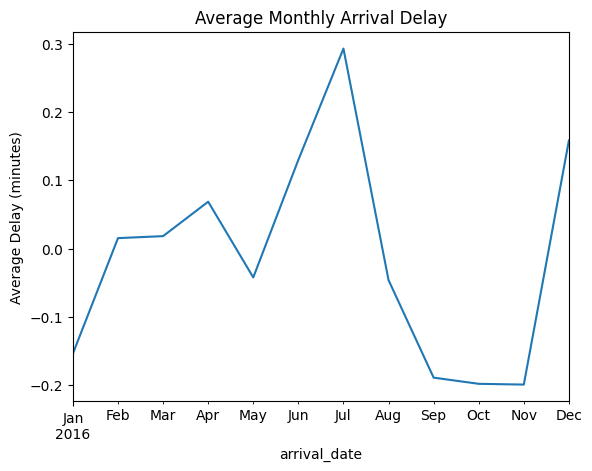

In [919]:
merged_data.set_index('arrival_date', inplace=True)
merged_data['arr_delay'].resample('M').mean().plot(title='Average Monthly Arrival Delay')
plt.ylabel('Average Delay (minutes)')
plt.show()

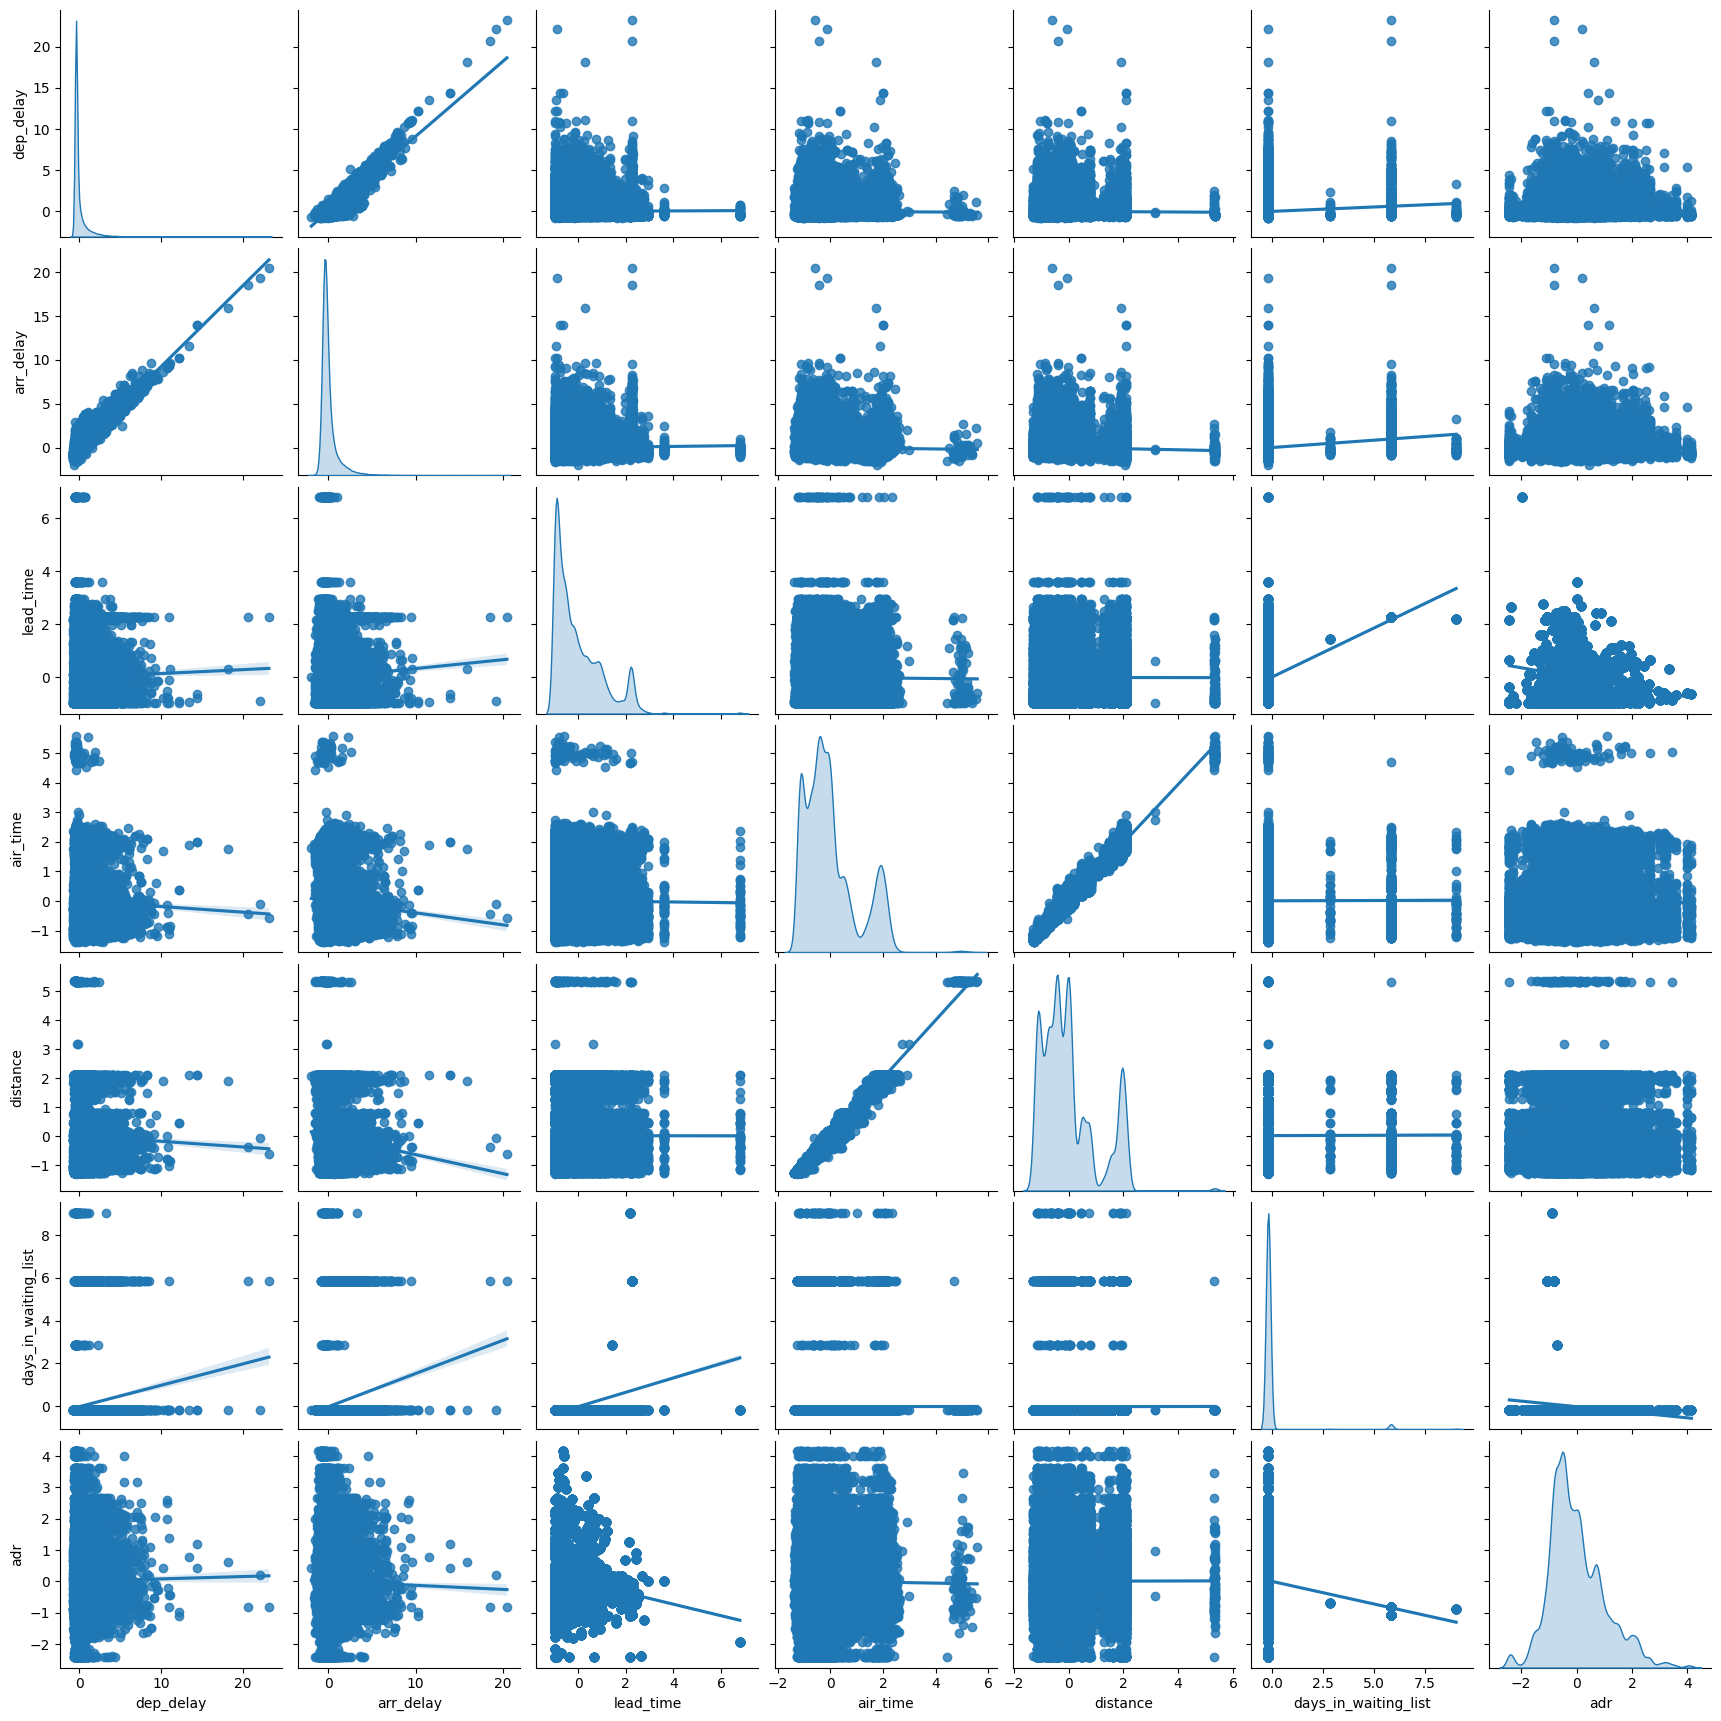

In [920]:
sample_data = merged_data.sample(frac=0.05)
numeric_cols = sample_data[continuous_features].dropna()
numeric_cols_cleaned = numeric_cols.replace([np.inf, -np.inf], np.nan).dropna()
numeric_cols = numeric_cols.reset_index(drop=True)
sns.pairplot(numeric_cols_cleaned, kind='reg', diag_kind='kde')

## Part 2: Answer questions from the proposals (8 points)

Each plot should be followed by a paragraph of explanation and observation.

### Creator: Rita Luo

#### Question: How do weekday and weekend patterns differ for flights and hotel stays?

In [97]:
merged_data.index = pd.to_datetime(merged_data.index)
merged_data['day_of_week'] = merged_data.index.dayofweek
merged_data['is_weekend'] = merged_data['day_of_week'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')
weekday_counts = merged_data['is_weekend'].value_counts()
weekday_counts

is_weekend
Weekday    611664
Weekend    289059
Name: count, dtype: int64

In [98]:
weekday_average = 470309/5
weekend_average = 223843/2
print(weekday_average,weekend_average)

94061.8 111921.5


In [99]:
merged_data['day_name'] = merged_data.index.day_name()
merged_data['day_name']

arrival_date
2016-01-01    Friday
2016-01-01    Friday
2016-01-01    Friday
2016-01-01    Friday
2016-01-01    Friday
               ...  
2016-09-30    Friday
2016-09-30    Friday
2016-09-30    Friday
2016-09-30    Friday
2016-09-30    Friday
Name: day_name, Length: 900723, dtype: object

In [100]:
flights_per_month = merged_data.groupby('month').size().reset_index(name='num_flights')
bookings_per_month = merged_data.groupby('month').size().reset_index(name='num_bookings')
booking_and_flights_per_month = flights_per_month.merge(bookings_per_month, on=['month'], how='outer')
booking_and_flights_per_month

,month,num_flights,num_bookings
0,1,21354,21354
1,2,25645,25645
2,3,70982,70982
3,4,75195,75195
4,5,76964,76964
5,6,112342,112342
6,7,111581,111581
7,8,81865,81865
8,9,118224,118224
9,10,99664,99664


#### Answer:

Since we've merged hotel booking and flights, they are the same in number as shown in booking_and_flights_per_month table. After calculation, there are 470309 in total hotel booking and flights in weekdays and 223843 on weekends. The average number of booking per day for weekday is 94061.8, while the average booking per day for weekend is 111921.5. This shown that more bookings are made during weekends.

### Interpreter 1: Conor Jones

#### Question: What is the association between lead time and cancellation for hotels?

In [101]:
canceled_lead_time = merged_data[merged_data['is_canceled'] == 1]['lead_time']
not_canceled_lead_time = merged_data[merged_data['is_canceled'] == 0]['lead_time']
print("canceled_lead_time")
print(canceled_lead_time.describe())
print("not_canceled_lead_time")
not_canceled_lead_time.describe()

canceled_lead_time
count    202181.000000
mean          0.105821
std           0.842779
min          -0.975151
25%          -0.545562
50%          -0.101653
75%           0.642967
max           2.676355
Name: lead_time, dtype: float64
not_canceled_lead_time


count    698542.000000
mean         -0.030628
std           1.039076
min          -0.975151
25%          -0.874913
50%          -0.431005
75%           0.499771
max           6.786088
Name: lead_time, dtype: float64

In [102]:
correlation = merged_data[['lead_time', 'is_canceled']].corr().iloc[0, 1]
correlation

0.05693064297524676

c:\Users\conor\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\conor\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\conor\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


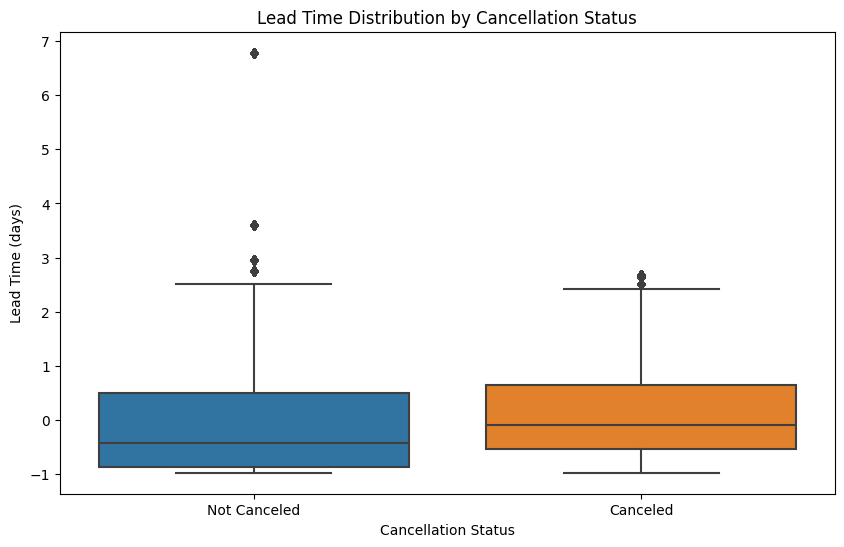

In [103]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_canceled', y='lead_time', data=merged_data)
plt.xticks([0, 1], ['Not Canceled', 'Canceled'])
plt.title("Lead Time Distribution by Cancellation Status")
plt.xlabel("Cancellation Status")
plt.ylabel("Lead Time (days)")
plt.show()

In [104]:
t_stat, p_value = ttest_ind(canceled_lead_time, not_canceled_lead_time)
t_stat, p_value

(54.118552418895334, 0.0)

c:\Users\conor\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\conor\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\conor\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


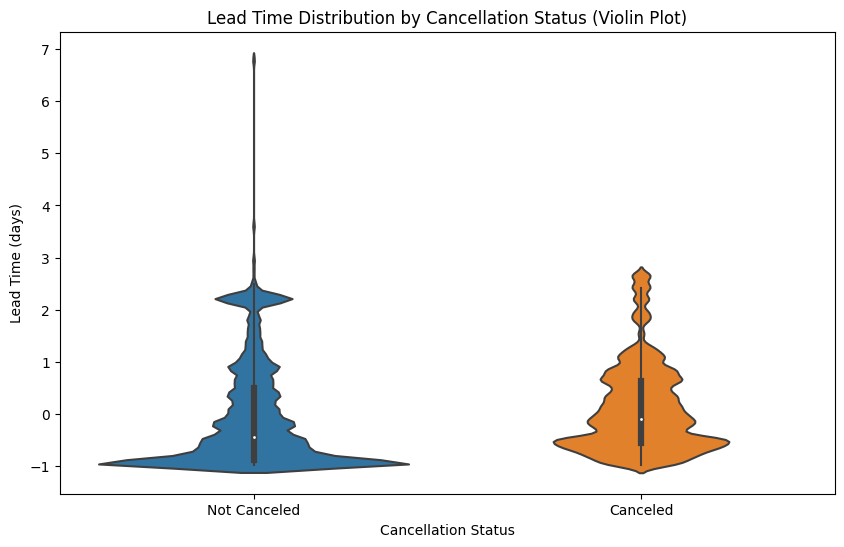

In [105]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='is_canceled', y='lead_time', data=merged_data)
plt.xticks([0, 1], ['Not Canceled', 'Canceled'])
plt.title("Lead Time Distribution by Cancellation Status (Violin Plot)")
plt.xlabel("Cancellation Status")
plt.ylabel("Lead Time (days)")
plt.show()

#### Answer:

By analyzing the descriptive statistics (mean, median, standard deviation) for canceled_lead_time and not_canceled_lead_time, we are examining if canceled bookings tend to have longer or shorter lead times on average. If the mean or median lead time for canceled bookings is notably higher than for non-canceled bookings, this suggests a possible relationship where longer lead times correlate with higher cancellation rates. 

Calculating the correlation between lead_time and is_canceled provides a quantitative measure of the association. If the correlation is positive and significant, it implies that bookings with longer lead times have a higher likelihood of cancellation. However, correlation alone doesn’t imply causation; it only signals an association.

The box plot visually compares the distributions of lead times for canceled and non-canceled bookings. The box plot shows a higher median, it suggests that cancellations are more common among bookings with longer lead times. 

The t-test assesses whether the difference in mean lead times between canceled and non-canceled bookings is statistically significant. A low p-value (typically <0.05) would indicate that the difference in lead times between these groups is unlikely due to random chance, strengthening the evidence that longer lead times might be associated with cancellations. Violin Plot:

The violin plot offers more detail on the distribution of lead times for each cancellation status by showing the density. The density for canceled bookings is concentrated at higher lead times compared to non-canceled bookings, this further supports the hypothesis that lead time influences cancellation likelihood. 

It is observed a significant positive correlation, a higher median lead time in the box plot for canceled bookings, and a statistically significant t-test result, it can be concluded that there is an association where longer lead times correlate with an increased likelihood of cancellation.


### Interpreter 2: Daniel Xu

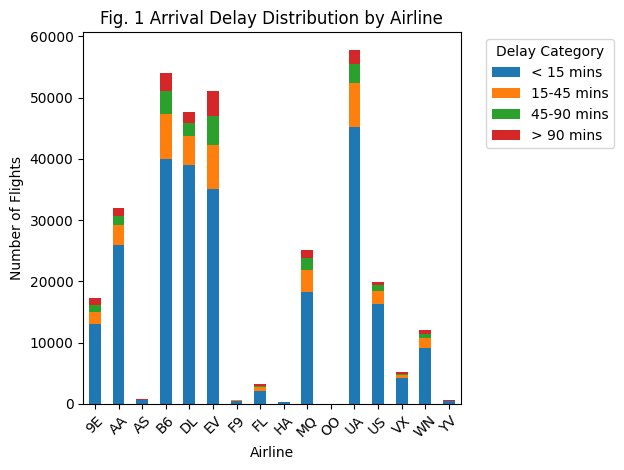

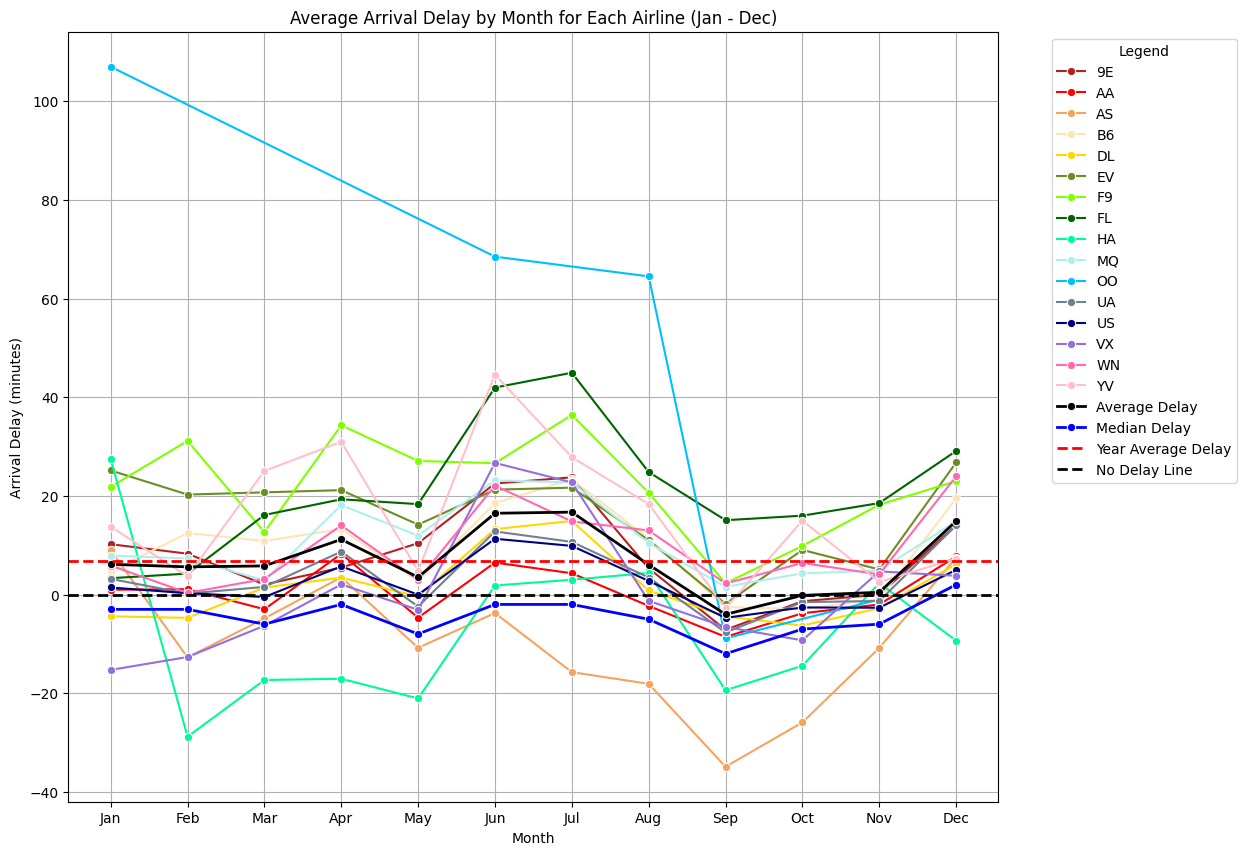

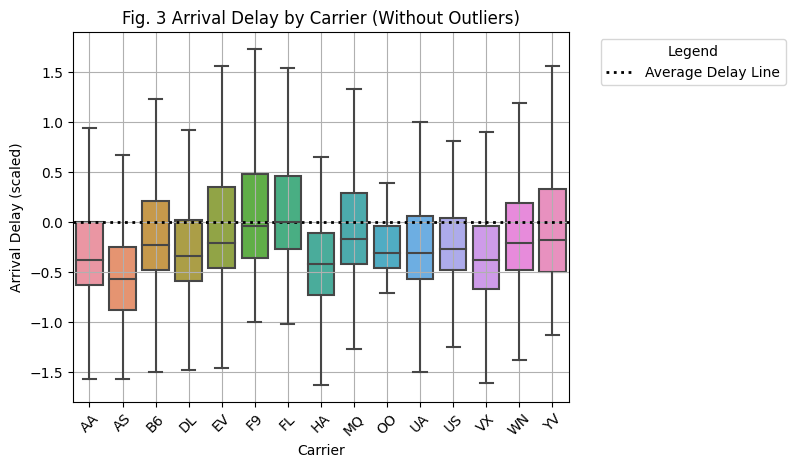

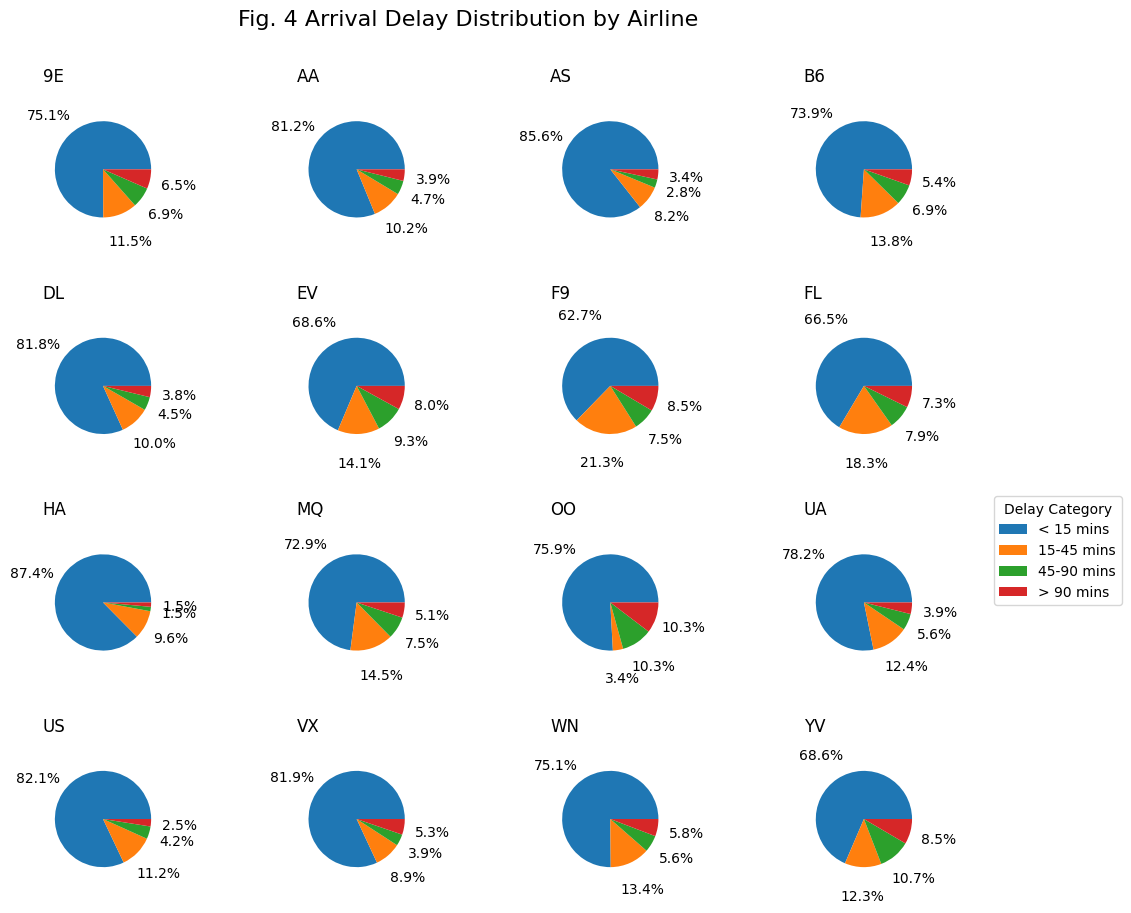

In [1070]:
#Useful visualizations
#Barchart
delay_bins = [-float('inf'), 15, 45, 90, float('inf')]
delay_labels = ['< 15 mins', '15-45 mins', '45-90 mins', '> 90 mins']
flights['delay_category'] = pd.cut(flights['arr_delay'], bins=delay_bins, labels=delay_labels)
delay_counts = flights.groupby(['carrier', 'delay_category']).size().unstack(fill_value=0)
delay_counts.plot(kind='bar', stacked=True)
plt.title('Fig. 1 Arrival Delay Distribution by Airline')
plt.xlabel('Airline')
plt.ylabel('Number of Flights')
plt.xticks(rotation=45)
plt.legend(title='Delay Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#Linechart
month_mapping = {1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12}
flights['month_numeric'] = flights['month'].map(month_mapping)
average_delay_per_month = (flights.groupby(['month_numeric', 'carrier'])['arr_delay'].mean().reset_index())
overall_average_delay_per_month = (flights.groupby('month_numeric')['arr_delay'].mean().reset_index().rename(columns={'arr_delay': 'overall_avg_delay'}))
overall_median_delay_per_month = (flights.groupby('month_numeric')['arr_delay'].median().reset_index().rename(columns={'arr_delay': 'overall_median_delay'}))
year_average_delay = flights['arr_delay'].mean()
unique_carriers = average_delay_per_month['carrier'].unique()
custom_colors = ['firebrick', 'red', 'sandybrown', 'moccasin', 'gold', 'olivedrab', 
                 'chartreuse', 'darkgreen', 'mediumspringgreen', 'paleturquoise', 
                 'deepskyblue', 'slategray', 'navy', 'mediumpurple', 'hotpink', 'pink']

plt.figure(figsize=(12, 10))
for i, carrier in enumerate(unique_carriers):
    sns.lineplot(data=average_delay_per_month[average_delay_per_month['carrier'] == carrier],
                 x='month_numeric',
                 y='arr_delay',
                 color=custom_colors[i],
                 marker='o',
                 label=carrier)
sns.lineplot(data=overall_average_delay_per_month, x='month_numeric', y='overall_avg_delay', color='black', marker='o', label='Average Delay', linewidth=2)
sns.lineplot(data=overall_median_delay_per_month, x='month_numeric', y='overall_median_delay', color='blue', marker='o', label='Median Delay', linewidth=2)
plt.axhline(y=year_average_delay, color='red', linestyle='--', label='Year Average Delay', linewidth=2)
plt.title('Average Arrival Delay by Month for Each Airline (Jan - Dec)')
plt.xlabel('Month')
plt.ylabel('Arrival Delay (minutes)')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.axhline(y=0, color='black', linewidth=2, linestyle='--', label='No Delay Line')
plt.grid(True)
plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

#Boxplots
# select only the carrier dummy columns
carrier_cols = [col for col in merged_data.columns if col.startswith("carrier_")]
df_carrier = merged_data[carrier_cols + ['arr_delay']]
# melt the data
df_carrier_melted = df_carrier.melt(id_vars=['arr_delay'], var_name='carrier', value_name='indicator')
df_carrier_melted = df_carrier_melted[df_carrier_melted['indicator'] == 1]
df_carrier_melted['carrier'] = df_carrier_melted['carrier'].str.replace("carrier_", "")

sns.boxplot(x='carrier', y='arr_delay', data=df_carrier_melted, showfliers=False)
plt.title('Fig. 3 Arrival Delay by Carrier (Without Outliers)')
plt.xlabel('Carrier')
plt.ylabel('Arrival Delay (scaled)')
plt.axhline(y=0, color='black', linewidth=2, linestyle=':', label='Average Delay Line')
plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

#Piecharts
delay_bins = [-float('inf'), 15, 45, 90, float('inf')]
delay_labels = ['< 15 mins', '15-45 mins', '45-90 mins', '> 90 mins']
flights['delay_category'] = pd.cut(flights['arr_delay'], bins=delay_bins, labels=delay_labels)
delay_counts = flights.groupby(['carrier', 'delay_category']).size().unstack(fill_value=0)

fig, axes = plt.subplots(4, 4, figsize=(12, 10), subplot_kw=dict(aspect="equal"))
axes = axes.flatten()
for i, (carrier, counts) in enumerate(delay_counts.iterrows()):
    ax = axes[i]
    wedges, texts, autotexts = ax.pie(counts, labels=None, autopct='%1.1f%%', pctdistance=1.6, labeldistance=1.5)
    ax.set_title(carrier, fontsize=12, loc='left', pad=20)
fig.legend(wedges, delay_labels, title='Delay Category', bbox_to_anchor=(1.05, 0.5))
plt.suptitle('Fig. 4 Arrival Delay Distribution by Airline', fontsize=16)
plt.subplots_adjust(wspace=0.5, hspace=0.8)
plt.show()

#### Question: How do airlines compare on scheduling accuracy?

#### Answer:

In our flights dataset, we had a number of choices to measure "scheduling accuracy". For example, the difference between the scheduled departure time and the actual departure time, or the actual airtime vs the expected airtime (calculated with difference between expected arrival and expected depature) to name a couple. In the end, we decided to explore the scheduling accuracy with respect to the arrival time, since this is arguably the most important focus for scheduling. It wouldn't matter if a flight departed early or traveled from origin to destination in less time than expected if the flight still arrives late. To explore scheduling accuracy, we created a number of data visualizations for our flights dataset, namely Stacked Bar Charts, a Line Chart, Boxplots, and Pie-Charts.

First, let's take a look at the Stacked Bar Charts. Since we want to explore how airlines -a categorical variable- compare on scheduling accuracy, we made our bars correspond to each airline. Next, we thought it would be insightful to separate delays into groups by how serious they are, since a 30-minute delay should be distinguished from a 120-minute delay. Furthermore, since the United States Federal Aviation Administration considers a flight to be delayed when it is 15 minutes later than its scheduled time, the lowest delay category is "< 15". With the Stacked Bar Charts, we observe that there is no extremities with regards to scheduling accuracy. Although we don't have an exact proportion for each delay category, the general pattern shows most arrivals less than 15 minutes late and fewer arrivals later than 15 minutes, 45 minutes, 90 minutes. However, a more apparent observation that also remains important is the non-uniform distribution. Some airlines such as UA, B6, and DL have many more flight records than other airlines, so their arrival performance will have greater weight and influence when it comes to entire data-set averages.

In the Boxplots, we can see how each airline performs with respect to the average. The data has been scaled by mean and standard deviation using the StandardScaler, so easier to grasp airline comparisons with each other. Many airlines have most flights with less delay than the average, but it should be noted that because the mean is not resistant to outliers, extreme outliers could be skewing the mean to become greater. Regardless, from the boxplots, appears we have a better visualization for comparing performance between airlines, as arrival delays are side-by-side. From the boxplots, it seems airlines such as AS, HA, and VX perform better with their 3rd quartile lines under the average, indicating that they perform better than most airlines with respect to arrival delay.

However, looking at all of the airline arrivals from the year may overlook an aspect: the date. Some airlines may perform better in one month while another airline performs better in another month. To explore this, we created a line chart for arrival delay throughout the months. Each airline has a line and its average delay by month is plotted. We also plotted lines for the average delay per month, median delay per month, no delay (at 0 minutes), and average delay for the year. From the linechart, overall, it appears that airlines perform worse in the summer months: June, July, and August, with many airlines having average arrival delays greater than the year average. The average delay by month reflects this as well as it's mostly below the year average during the most of the other months, but increases during June and July. Once again, the median is lower than the mean, most likely because of outliers. Airline 'OO' only has data from Janurary, June, August, September, and November, which explains its irregular line plot without points at every month. From the lineplot, it looks like HA, AS, and AA perform better throughout the months with its monthly averages belowe monthly averages for all airlines combined. But the lineplot fails to show an exact proportion of flights falling in a particular delay range, a problem that also arose in from Stacked Bar Charts.

Finally, we created Pie Charts for each airline's arrival delay. Because the mean is not resistant to outliers, that means a few extremely long delays could lead to a mostly on-time airline to have a greater average and rank lower, even though most in most cases, delays are not common. With Pie Charts, we once again seaprate our delays into groups. This time, instead of counts, we did it by proportion. From the Pie Charts, we observe HA, AS, and US to have the greatest proportion of "on-time" arrivals with 87.4%, 85.6%, and 82.1% respectively. Still, there are other factors to consider depending on context. For example, if one has a longer layover and can afford a longer delay, they may prefer US over AS. Even though US has 82.1% of "on-time" arrivals compared with 85.6% of AS, US has 97.5% under 90 minutes while AS has 96.6% under 90 minutes.

In conclusion, there are many factors and visualizations we can use to explore how airline scheduling accuracy compares. Focusing on the Barchart, Line chart, Boxplots, and Pie Charts above, HA and AS arguably perform better.

### Deliverer: Sichen Li

#### Question: Which is the best month to travel to avoid the peak season?

In [107]:
merged_data['month']

arrival_date
2016-01-01    1
2016-01-01    1
2016-01-01    1
2016-01-01    1
2016-01-01    1
             ..
2016-09-30    9
2016-09-30    9
2016-09-30    9
2016-09-30    9
2016-09-30    9
Name: month, Length: 900723, dtype: int32

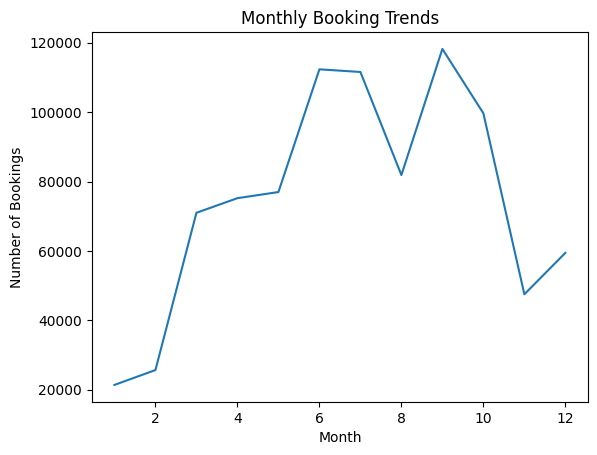

In [108]:
monthly_bookings = merged_data.groupby('month').size()
monthly_bookings.plot( title="Monthly Booking Trends", xlabel="Month", ylabel="Number of Bookings")
plt.show()

Based on the above barplot, January along with February has the least bookings and arrivals among all the twelve months, with September, June and July being the months with great numbers of travelers.

In [ ]:
merged_data['arr_delay'].mean().resample('M').plot(kind='line', title='Average Monthly Arrival Delay')
plt.ylabel('Average Delay (minutes)')
plt.xlabel('Month')
plt.show()

KeyError: "None of ['time_hour'] are in the columns"

Based on the above lineplot, January, May, and September tend to have relatively slighter delays of arrival, while July is the month with the highest average monthly arrival delay.


#### Answer:

In summary of the data graph analysis above, January and February tend to exhibit lowest number of travelers. Since February displays higher average month arrival delays, January could be the month best suitable to avoid peaks of traveling and minimizing potential arrival delays.

## Part 3: Follow-up Questions (4 points)

### New Questions Based Off Initial Investigation

- Q1: Does the day of the week impact the likelihood of cancellation for bookings with longer lead times?

We observed that bookings with longer lead times tend to have higher cancellation rates, but it’s unclear if this pattern varies by the day of the week. Analyzing cancellations by weekday and weekend could reveal if certain days (like weekends, when more leisure travel occurs) have stronger lead-time-cancellation associations. This could help identify if the timing within a week plays a role in the likelihood of cancellations for longer lead times.
- Q2: Does seasonality affect the relationship between lead time and cancellation rates?

Given that certain times of the year (e.g., summer months) experience higher travel volumes and delays, it would be insightful to explore if the lead time-cancellation association varies by season. Analyzing this could reveal whether customers who book far in advance are more likely to cancel during peak travel periods or if this trend is consistent year-round. Additionally, we could investigate if specific months exhibit different cancellation patterns due to external factors like weather or holiday demand.

c:\Users\conor\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\conor\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\conor\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\conor\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

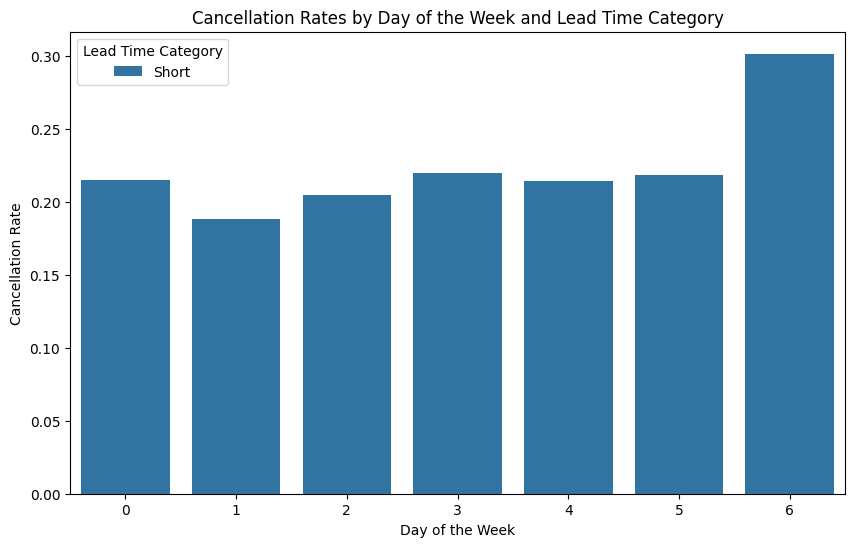

In [116]:
lead_time_threshold = 30  # Days

merged_data['lead_time_category'] = merged_data['lead_time'].apply(lambda x: 'Long' if x >= lead_time_threshold else 'Short')

day_lead_time_cancellation = (
    merged_data.groupby(['day_of_week', 'lead_time_category'])['is_canceled']
    .mean()
    .reset_index()
)

plt.figure(figsize=(10, 6))
sns.barplot(data=day_lead_time_cancellation, x='day_of_week', y='is_canceled', hue='lead_time_category')
plt.title('Cancellation Rates by Day of the Week and Lead Time Category')
plt.xlabel('Day of the Week')
plt.ylabel('Cancellation Rate')
plt.legend(title='Lead Time Category')
plt.show()


c:\Users\conor\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\conor\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\conor\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\conor\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

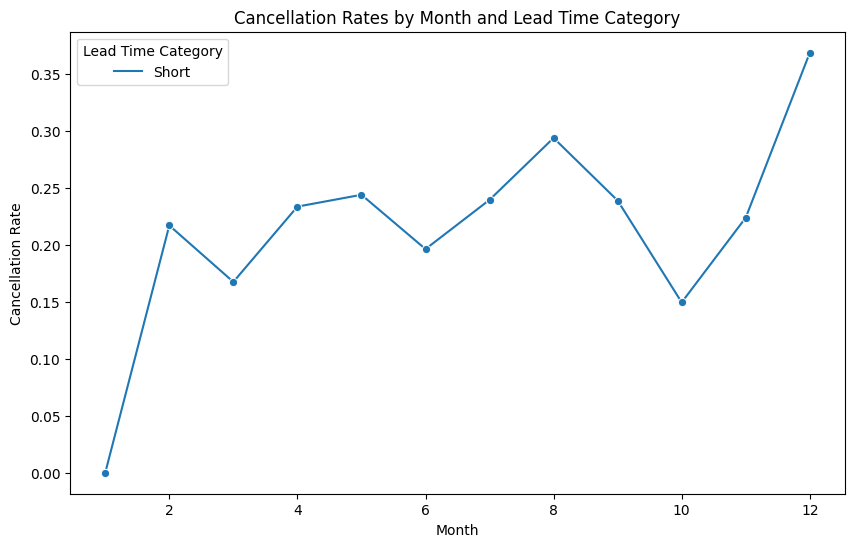

In [117]:
month_lead_time_cancellation = (
    merged_data.groupby(['month', 'lead_time_category'])['is_canceled']
    .mean()
    .reset_index()
)
plt.figure(figsize=(10, 6))
sns.lineplot(data=month_lead_time_cancellation, x='month', y='is_canceled', hue='lead_time_category', marker='o')
plt.title('Cancellation Rates by Month and Lead Time Category')
plt.xlabel('Month')
plt.ylabel('Cancellation Rate')
plt.legend(title='Lead Time Category')
plt.show()


## Summary (2 points)

GIVE A 2 PARAGRAPH SUMMARY. 

PARAGRAPH 1 SHOULD DESCRIBE WHAT YOU LEARNED ABOUT YOUR DATA FROM INVESTIGATING THE INITIAL QUESTIONS. DID YOU FIND ANYTHING UNUSUAL IN YOUR DATA? DID ANYTHING SURPRISE YOU? WHICH OF THE INITIAL QUESTIONS WERE HELPFUL IN LEADING YOU TO MORE QUESTIONS?

PARAGRAPH 2 SHOULD SUMMARIZE WHAT YOU LEARNED FROM INVESTIGATING THE FOLLOW-UP QUESTIONS. WHY ARE THESE FOLLOW-UP QUESTIONS INTERESTING FOR INVESTIGATION? DESCRIBE THE TABLES/FIGURES YOU USED TO EXPLORE ANSWERS TO THESE FOLLOW-UP QUESTIONS? WHAT DID YOU LEARN FROM THE TABLES/FIGURES REGARDING THE FOLLOW-UP QUESTIONS YOU PROPOSED?